In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [18]:
# Завантаження даних
walk_accel_data = pd.read_csv('walk/Accelerometer.csv')
walk_gyro_data = pd.read_csv('walk/Gyroscope.csv')
run_accel_data = pd.read_csv('run/Accelerometer.csv')
run_gyro_data = pd.read_csv('run/Gyroscope.csv')
squat_accel_data = pd.read_csv('squat/Accelerometer.csv')
squat_gyro_data = pd.read_csv('squat/Gyroscope.csv')

In [19]:
# Позначення колонок
walk_accel_data.columns = [f'accel_{col}' for col in walk_accel_data.columns]
walk_gyro_data.columns = [f'gyro_{col}' for col in walk_gyro_data.columns]
run_accel_data.columns = [f'accel_{col}' for col in run_accel_data.columns]
run_gyro_data.columns = [f'gyro_{col}' for col in run_gyro_data.columns]
squat_accel_data.columns = [f'accel_{col}' for col in squat_accel_data.columns]
squat_gyro_data.columns = [f'gyro_{col}' for col in squat_gyro_data.columns]
# Об'єднання даних
walk_data = pd.concat([walk_accel_data, walk_gyro_data], axis=1)
run_data = pd.concat([run_accel_data, run_gyro_data], axis=1)
squat_data = pd.concat([squat_accel_data, squat_gyro_data], axis=1)
# Додавання міток активності
walk_data['activity'] = '0'
run_data['activity'] = '1'
squat_data['activity'] = '2'
# Об'єднання всіх даних
all_data = pd.concat([walk_data, run_data, squat_data], ignore_index=True)
all_data.head()

,accel_time,accel_seconds_elapsed,accel_z,accel_y,accel_x,gyro_time,gyro_seconds_elapsed,gyro_z,gyro_y,gyro_x,activity
0,1.710738e+18,0.297091,0.000000,0.000000,0.000000,1710737800444874200,0.300874,0.545563,0.491198,1.057453,0
1,1.710738e+18,0.354975,0.198684,0.781952,-0.352732,1710737800478207200,0.334207,0.419499,0.096743,0.097583,0
2,1.710738e+18,0.412859,0.568994,-0.512807,-0.047651,1710737800511540200,0.367540,0.541134,-0.485089,-0.245561,0
3,1.710738e+18,0.470744,1.105880,-0.558323,-1.035443,1710737800544873200,0.400873,0.481500,-1.089446,-0.071622,0
4,1.710738e+18,0.528628,0.481292,-2.411216,-1.289307,1710737800578206200,0.434206,0.100637,-1.012708,-0.643909,0


In [20]:
# Перевірка на пропущені значення
if all_data.isnull().values.any():
    print("Data contains NaN values. Filling with zeros.")
    all_data = all_data.fillna(0)
    
all_data.head()

Data contains NaN values. Filling with zeros.


,accel_time,accel_seconds_elapsed,accel_z,accel_y,accel_x,gyro_time,gyro_seconds_elapsed,gyro_z,gyro_y,gyro_x,activity
0,1.710738e+18,0.297091,0.000000,0.000000,0.000000,1710737800444874200,0.300874,0.545563,0.491198,1.057453,0
1,1.710738e+18,0.354975,0.198684,0.781952,-0.352732,1710737800478207200,0.334207,0.419499,0.096743,0.097583,0
2,1.710738e+18,0.412859,0.568994,-0.512807,-0.047651,1710737800511540200,0.367540,0.541134,-0.485089,-0.245561,0
3,1.710738e+18,0.470744,1.105880,-0.558323,-1.035443,1710737800544873200,0.400873,0.481500,-1.089446,-0.071622,0
4,1.710738e+18,0.528628,0.481292,-2.411216,-1.289307,1710737800578206200,0.434206,0.100637,-1.012708,-0.643909,0


In [21]:
# Функції для обчислення статистик
def calculate_std_within_window(window):
    return np.std(window)

def calculate_mean_activity_within_window(window):
    return round(np.mean(window))

def calculate_median_within_window(window):
    return np.median(window)

# Розділення датасету на вікна
window_size = 30
num_windows = len(all_data) // window_size
windows = [all_data.iloc[i*window_size:(i+1)*window_size] for i in range(num_windows)]

# Обчислення статистик для кожного вікна
accel_z_std_list = []
accel_y_std_list = []
accel_x_std_list = []
gyro_z_std_list = []
gyro_y_std_list = []
gyro_x_std_list = []
accel_z_median_list = []
accel_y_median_list = []
accel_x_median_list = []
gyro_z_median_list = []
gyro_y_median_list = []
gyro_x_median_list = []
activity_list = []

for window in windows:
    accel_z_std = calculate_std_within_window(window['accel_z'])
    accel_y_std = calculate_std_within_window(window['accel_y'])
    accel_x_std = calculate_std_within_window(window['accel_x'])
    gyro_z_std = calculate_std_within_window(window['gyro_z'])
    gyro_y_std = calculate_std_within_window(window['gyro_y'])
    gyro_x_std = calculate_std_within_window(window['gyro_x'])
    
    accel_z_median = calculate_median_within_window(window['accel_z'])
    accel_y_median = calculate_median_within_window(window['accel_y'])
    accel_x_median = calculate_median_within_window(window['accel_x'])
    gyro_z_median = calculate_median_within_window(window['gyro_z'])
    gyro_y_median = calculate_median_within_window(window['gyro_y'])
    gyro_x_median = calculate_median_within_window(window['gyro_x'])
    
    window.loc[:, 'activity'] = pd.to_numeric(window['activity'])
    activity = calculate_mean_activity_within_window(window['activity'])
    
    accel_z_std_list.append(accel_z_std)
    accel_y_std_list.append(accel_y_std)
    accel_x_std_list.append(accel_x_std)
    gyro_z_std_list.append(gyro_z_std)
    gyro_y_std_list.append(gyro_y_std)
    gyro_x_std_list.append(gyro_x_std)
    
    accel_z_median_list.append(accel_z_median)
    accel_y_median_list.append(accel_y_median)
    accel_x_median_list.append(accel_x_median)
    gyro_z_median_list.append(gyro_z_median)
    gyro_y_median_list.append(gyro_y_median)
    gyro_x_median_list.append(gyro_x_median)
    
    activity_list.append(activity)

# Створення нового датасету з обчисленими значеннями
new_data = pd.DataFrame({
    'accel_z_std': accel_z_std_list,
    'accel_y_std': accel_y_std_list,
    'accel_x_std': accel_x_std_list,
    'gyro_z_std': gyro_z_std_list,
    'gyro_y_std': gyro_y_std_list,
    'gyro_x_std': gyro_x_std_list,
    'accel_z_median': accel_z_median_list,
    'accel_y_median': accel_y_median_list,
    'accel_x_median': accel_x_median_list,
    'gyro_z_median': gyro_z_median_list,
    'gyro_y_median': gyro_y_median_list,
    'gyro_x_median': gyro_x_median_list,
    'activity': activity_list
})

# Перемішування даних
new_data_shuffled = new_data.sample(frac=1)
new_data_shuffled.head()

,accel_z_std,accel_y_std,accel_x_std,gyro_z_std,gyro_y_std,gyro_x_std,accel_z_median,accel_y_median,accel_x_median,gyro_z_median,gyro_y_median,gyro_x_median,activity
92,1.193774,2.715552,3.677100,1.088965,0.683824,0.542526,-0.225815,-0.968747,-0.284305,0.399876,0.101668,0.008170,0
281,0.960567,6.025594,4.976960,2.794889,0.562958,0.753703,0.508282,-3.269485,7.541134,1.423923,0.064750,-0.403159,1
168,0.000000,0.000000,0.000000,1.433194,0.706362,0.489442,0.000000,0.000000,0.000000,0.553275,0.025007,-0.146642,0
438,3.352480,0.970001,1.277909,0.276642,0.232302,0.352090,2.224581,0.482715,0.369580,0.175046,0.046844,-0.112778,2
378,5.467428,0.907334,1.072705,0.621238,0.507172,1.377717,1.167425,-0.069450,-0.175374,-0.258427,0.219981,0.129423,2


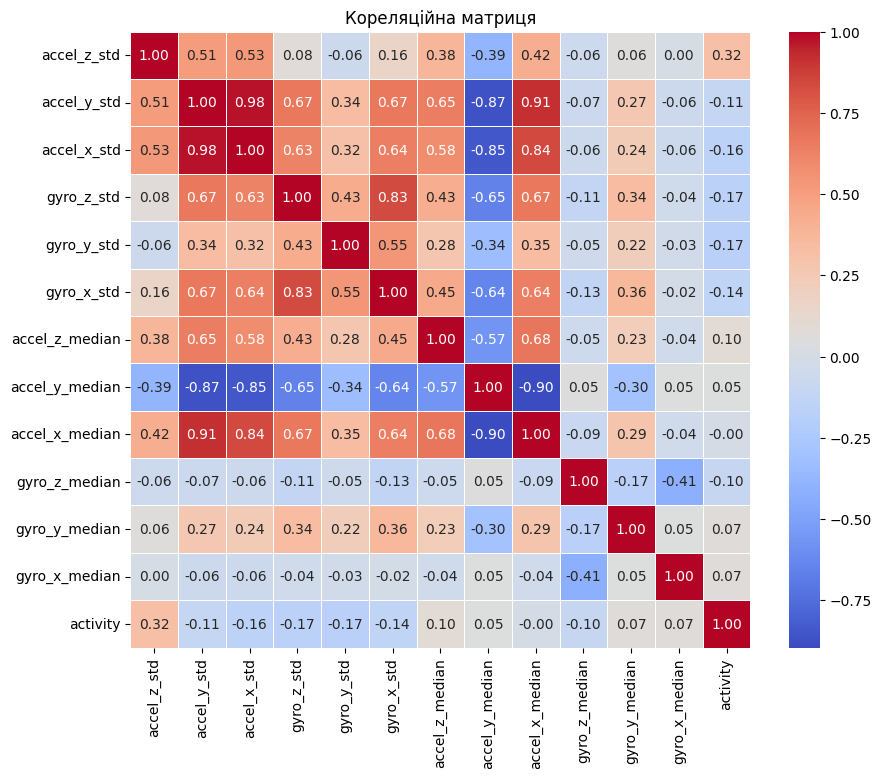

In [22]:
correlation_matrix = new_data_shuffled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця')
plt.show()

In [23]:

# Вибірка ознак та цільової змінної
features = new_data_shuffled.iloc[:, :-1]
target = new_data_shuffled['activity']

# Розбиття даних на тренувальний та валідаційний набори
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.3, random_state=42)

# Нормалізація даних
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [24]:

# Конвертація даних у тензори PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)

# Створення класу моделі
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Збільшена кількість нейронів
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Ініціалізація моделі та визначення гіперпараметрів
input_size = X_train.shape[1]
output_size = len(new_data['activity'].unique())
model = NeuralNetwork(input_size, output_size)

# Ініціалізація вагів
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

model.apply(init_weights)

NeuralNetwork(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [29]:

# Визначення втрати та оптимізатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Зменшення швидкості навчання

# Тренування моделі
num_epochs = 500 # Збільшення кількості епох
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оцінка точності моделі
model.eval()
with torch.no_grad():
    val_output = model(X_val)
    _, predicted = torch.max(val_output, 1)
    correct = (predicted == y_val).sum().item()
    accuracy = correct / len(y_val)

# Виведення значення точності
print(f"Validation Accuracy: {accuracy}")


Epoch [20/500], Loss: 0.1560
Epoch [40/500], Loss: 0.1448
Epoch [60/500], Loss: 0.1379
Epoch [80/500], Loss: 0.1560
Epoch [100/500], Loss: 0.1676
Epoch [120/500], Loss: 0.1769
Epoch [140/500], Loss: 0.1522
Epoch [160/500], Loss: 0.1580
Epoch [180/500], Loss: 0.1602
Epoch [200/500], Loss: 0.1608
Epoch [220/500], Loss: 0.1559
Epoch [240/500], Loss: 0.1615
Epoch [260/500], Loss: 0.1334
Epoch [280/500], Loss: 0.1279
Epoch [300/500], Loss: 0.1573
Epoch [320/500], Loss: 0.1322
Epoch [340/500], Loss: 0.1601
Epoch [360/500], Loss: 0.1427
Epoch [380/500], Loss: 0.1217
Epoch [400/500], Loss: 0.1684
Epoch [420/500], Loss: 0.1390
Epoch [440/500], Loss: 0.1148
Epoch [460/500], Loss: 0.1298
Epoch [480/500], Loss: 0.1243
Epoch [500/500], Loss: 0.1201
Validation Accuracy: 0.9707602339181286
